# Create a polynomial chaos metamodel

In this example we are going to create a global approximation of a model response using functional chaos.

Let $h$ be the function defined by:

$$
g(\mathbf{x}) = \left[\cos(x_1 + x_2), (x_2 + 1) e^{x_1}\right]
$$

for any $\mathbf{x}\in\mathbb{R}^2$. 

We assume that 

$$
X_1 \sim \mathcal{N}(0,1) \textrm{ and }
X_2 \sim \mathcal{N}(0,1)
$$

and that $X_1$ and $X_2$ are independent.

An interesting point in this example is that the output is multivariate. This is why we are going to use the `getMarginal` method in the script in order to select the output marginal that we want to manage. 

In [1]:
from __future__ import print_function
import openturns as ot

We first create the function `model`.

In [2]:
ot.RandomGenerator.SetSeed(0)
dimension = 2
input_names = ['x1', 'x2']
formulas = ['cos(x1 + x2)', '(x2 + 1) * exp(x1)']
model = ot.SymbolicFunction(input_names, formulas)

Then we create a sample `inputSample` and compute the corresponding output sample `outputSample`.

In [3]:
distribution = ot.Normal(dimension)
samplesize = 100
inputSample  = distribution.getSample(samplesize)
outputSample = model(inputSample)

Create a functional chaos model. We reduce the sampling size for the automatic selection of distribution based on Kolmogorov test.

In [4]:
ot.ResourceMap.SetAsUnsignedInteger("FittingTest-KolmogorovSamplingSize", 100)

In [5]:
algo = ot.FunctionalChaosAlgorithm(inputSample, outputSample)
algo.run()
result = algo.getResult()
metamodel = result.getMetaModel()

Plot the second output of our model depending on $x_2$ with $x_1=0.5$. In order to do this, we create a `ParametricFunction` and set the value of $x_1$. Then we use the `getMarginal` method to extract the second output (which index is equal to 1). 

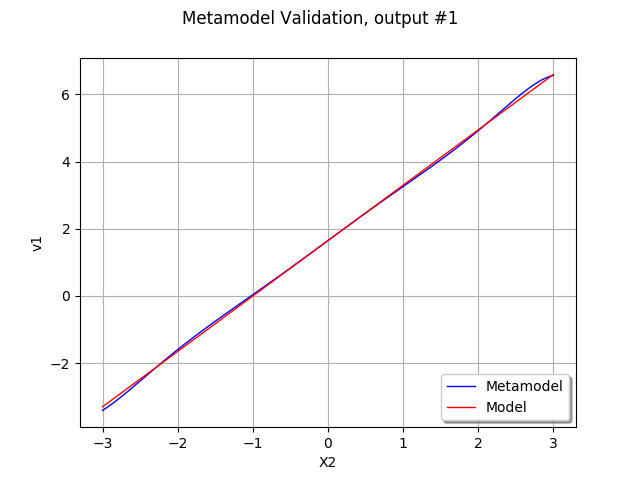

In [6]:
x1index = 0
x1value = 0.5
x2min = -3.
x2max = 3.
outputIndex = 1
metamodelParametric = ot.ParametricFunction(metamodel, [x1index], [x1value])
graph = metamodelParametric.getMarginal(outputIndex).draw(x2min, x2max)
graph.setLegends(["Metamodel"])
modelParametric = ot.ParametricFunction(model, [x1index], [x1value])
curve = modelParametric.getMarginal(outputIndex).draw(x2min, x2max).getDrawable(0)
curve.setColor('red')
curve.setLegend("Model")
graph.add(curve)
graph.setLegendPosition("bottomright")
graph.setXTitle("X2")
graph.setTitle("Metamodel Validation, output #%d" % (outputIndex))
graph

We see that the metamodel fits approximately to the model, except perhaps for extreme values of $x_2$. However, there is a better way of globally validating the metamodel, using the `MetaModelValidation` on a validation design of experiment. 

In [7]:
n_valid = 100
inputTest = distribution.getSample(n_valid)
outputTest = model(inputTest)

The following function takes the `outputIndex` as input argument and plots the corresponding validation graphics. 

In [8]:
def drawValidation(inputTest,outputTest,metamodel,outputIndex):
    val = ot.MetaModelValidation(inputTest, outputTest[:,outputIndex], metamodel.getMarginal(outputIndex))
    Q2 = val.computePredictivityFactor()
    graph = val.drawValidation()
    graph.setTitle("Validation of output #%d, Q2 = %.2f%%" % (outputIndex,Q2*100))
    graph.setLegends([""])
    return graph

Let us first validate the first output. 

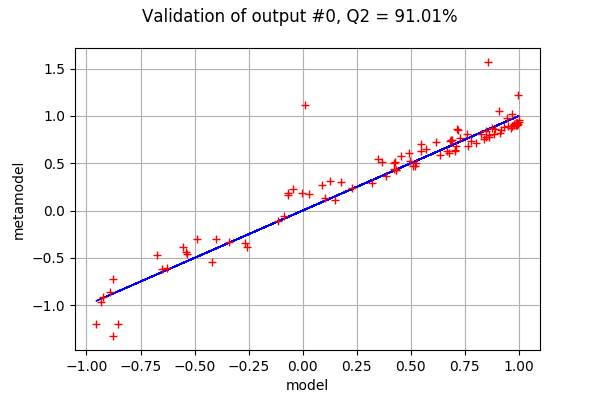

In [9]:
outputIndex = 0
drawValidation(inputTest,outputTest,metamodel,outputIndex)

The coefficient of predictivity is not extremely satisfactory for this output, but is would be sufficient for a central dispersion study. 

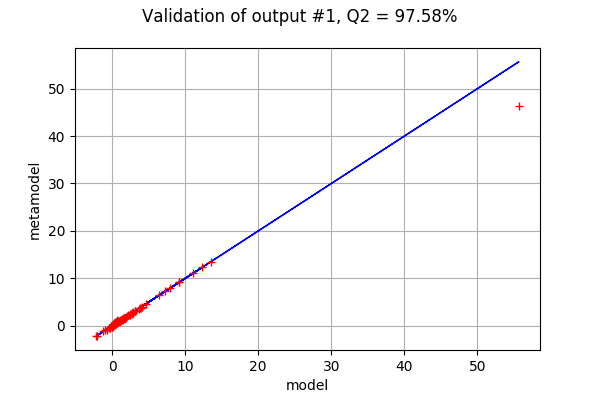

In [10]:
outputIndex = 1
drawValidation(inputTest,outputTest,metamodel,outputIndex)

The second output has a much more satisfactory Q2: only one single extreme point is far from the diagonal of the graphics.

## Compute and print Sobol' indices

In [11]:
chaosSI = ot.FunctionalChaosSobolIndices(result) 
print(chaosSI.summary())

 input dimension: 2
 output dimension: 2
 basis size: 17
 mean: [0.364321,1.46479]
 std-dev: [0.742595,4.46299]
------------------------------------------------------------
Marginal: 0
Index   | Multi-indice                  | Part of variance  
------------------------------------------------------------
      6 | [1,1]                         | 0.308586
     12 | [3,1]                         | 0.213701
     14 | [2,2]                         | 0.173489
      4 | [0,2]                         | 0.169134
      3 | [2,0]                         | 0.134698
------------------------------------------------------------


------------------------------------------------------------
Component | Sobol index            | Sobol total index      
------------------------------------------------------------
        0 | 0.134698               | 0.830473              
        1 | 0.169527               | 0.865302              
------------------------------------------------------------

Marginal: 

Let us analyse the results of this global sensitivity analysis.

* We see that the first output involves significant multi-indices with total degree 4. The contribution of the interactions are very significant in this model. 
* The second output involves multi-indices with total degrees from 1 to 7, with a significant contribution of multi-indices with total degress 5 and 7. The first variable is especially significant, with a significant contribution of the interactions. 

Draw Sobol' indices.

In [12]:
sensitivityAnalysis = ot.FunctionalChaosSobolIndices(result)
first_order = [sensitivityAnalysis.getSobolIndex(i) for i in range(dimension)]
total_order = [sensitivityAnalysis.getSobolTotalIndex(i) for i in range(dimension)]

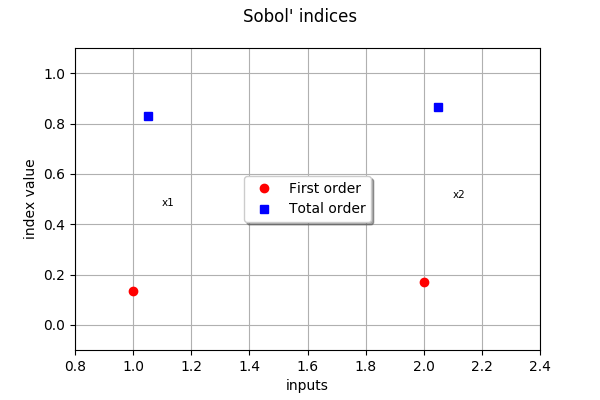

In [13]:
input_names = model.getInputDescription()
graph = ot.SobolIndicesAlgorithm.DrawSobolIndices(input_names, first_order, total_order)
graph.setLegendPosition("center")
graph

## Testing the sensitivity to the degree

With the specific constructor of `FunctionalChaosAlgorithm` that we use, the `FunctionalChaosAlgorithm-MaximumTotalDegree` in the `ResourceMap` configure the maximum degree explored by the algorithm. This degree is a trade-off. 

* If the maximum degree is too low, the polynomial may miss some coefficients so that the quality is lower than possible.
* If the maximum degree is too large, the number of coefficients to explore is too large, so that the coefficients might be poorly estimated. 

This is why the following `for` loop explores various degrees to see the sensitivity of the metamodel predictivity depending on the degree.

The default value of this parameter is 10.

In [14]:
ot.ResourceMap.GetAsUnsignedInteger("FunctionalChaosAlgorithm-MaximumTotalDegree")

10

This is why we explore the values from 5 to 15.

In [28]:
degrees = ot.Sample([[i] for i in range(5,15)])
numberOfDegrees = degrees.getSize()
coefficientOfPredictivity = ot.Sample(numberOfDegrees,2)
for maximumDegree in range(5,15):
    ot.ResourceMap.SetAsUnsignedInteger("FunctionalChaosAlgorithm-MaximumTotalDegree",maximumDegree)
    print("Maximum total degree =", maximumDegree)
    algo = ot.FunctionalChaosAlgorithm(inputSample, outputSample)
    algo.run()
    result = algo.getResult()
    metamodel = result.getMetaModel()
    for outputIndex in range(2):
        val = ot.MetaModelValidation(inputTest, outputTest[:,outputIndex], metamodel.getMarginal(outputIndex))
        Q2 = val.computePredictivityFactor()
        coefficientOfPredictivity[maximumDegree-5,outputIndex] = Q2

Maximum total degree = 5
Maximum total degree = 6
Maximum total degree = 7
Maximum total degree = 8
Maximum total degree = 9
Maximum total degree = 10
Maximum total degree = 11
Maximum total degree = 12
Maximum total degree = 13
Maximum total degree = 14


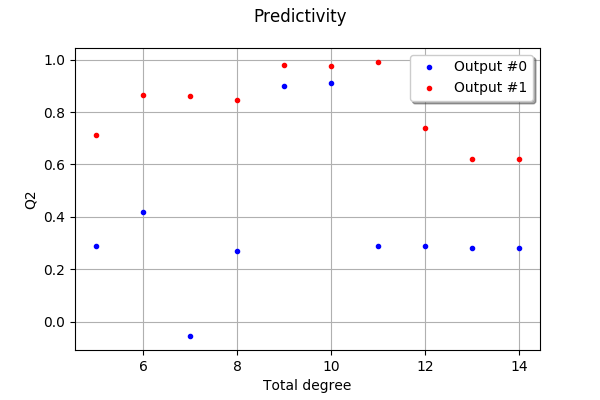

In [24]:
graph = ot.Graph("Predictivity","Total degree","Q2",True)
cloud = ot.Cloud(degrees,coefficientOfPredictivity[:,0])
cloud.setLegend("Output #0")
cloud.setPointStyle("bullet")
graph.add(cloud)
cloud = ot.Cloud(degrees,coefficientOfPredictivity[:,1])
cloud.setLegend("Output #1")
cloud.setColor("red")
cloud.setPointStyle("bullet")
graph.add(cloud)
graph.setLegendPosition("topright")
graph

We see that a total degree lower than 9 is not sufficient to describe the first output with good predictivity. However, the coefficient of predictivity drops when the total degree gets greater than 12. 
The predictivity of the second output seems to be much less satisfactory: a little more work would be required to improve the metamodel. 

In this situation, the following methods may be used. 

* Since the distribution of the input is known, we may want to give this information to the `FunctionalChaosAlgorithm`. This prevents the algorithm from trying to fit the distribution which best fit to the data. 
* We may want to customize the `adaptiveStrategy` by selecting an enumerate function which best fit to this particular situation. In this specific example, the interactions plays a great role so that the linear enumerate function may provide better results than the hyperbolic rule.
* We may want to customize the `projectionStrategy` by selecting an method to compute the coefficient which improves the estimation. Given that the function is symbolic and fast, it might be interesting to try an integration rule instead of the least squares method.